## Python assessments

This section should be completed using Python, and the “Pandas” package (https://pandas.pydata.org/). 

Note that ultimately all created code should be formatted into a **Python package** and the creation and proper documentation of functions is recommended. 

Using the same GWAS summary statistics file as above, do the following:

### Question 1

Read the GWAS summary statistics into a Pandas DataFrame.

Solution:

Refer to source code for implementation:

  Function: clean_sumstats()

### Question 2


Perform data cleaning by removing rows without a valid rsid number and save the
cleaned data. This new dataset will be used in another step below.

1. How many invalid rsids are there?
2. The genome-wide significance p-value is 5e-8, how many SNPs in the file are genome-wide significant?

In [4]:
# assumes the cleaned files are created.
import matplotlib.pyplot as plt
import seaborn as sns
import os,shutil,sys,re,csv
import pandas as pd
import numpy as np

In [ ]:
sumstat_file="/Users/kevinliang/Desktop/work/working/interview_prep/5prime/5PrimeSciences_coding_assessments/data/cleaned_sumstats.txt.gz"
sumstat_res = pd.read_csv(sumstat_file,sep="\t",quoting=csv.QUOTE_NONE)

original_file="/Users/kevinliang/Desktop/work/working/interview_prep/5prime/5PrimeSciences_coding_assessments/data/fn2stu.MAF0_.005.pos_.out_.gz"
original_sumstats = pd.read_csv(original_file,sep="\t",quoting=csv.QUOTE_NONE)

# re.match matches the beginning of string
valid_snps = original_sumstats['rs_number'].apply(lambda val: bool(re.match("rs",val)))
n_invalid = np.sum([not x for x in valid_snps])
valid_snps = np.sum(valid_snps)

# sig variants
np.sum(sumstat_res['p-value'] <= 5e-8)

Solution:

  1. There are 1,116,848 rows with invalid RSID (i.e., does not have the format: "rs####")

Solution:

2. 879 variants within the cleaned files have p-values less than or equal to 5e-8

### Question 3

Identify the most significant SNP in the 500 Kb region centred on chromosome 7 at
position 121012647.

In [2]:

# obtain the 500kb region around the variant we need
## get the most significant snp as before
targ_chrom = 7
targ_pos = 121012647
min_pos = targ_pos - 500_000
max_pos = targ_pos + 500_000
relevant_region = sumstat_res.query(
  f"chromosome == {targ_chrom} & position <= {max_pos} & position >= {min_pos}"
)
most_significant = relevant_region[relevant_region['p-value'] == relevant_region['p-value'].min()]
assert(len(most_significant) == 1),f"more than 1 sig snps...probably pick one first"

Solution:

  The most significant variant in this region is rs3779381 (chr7:120966790).
  
  p-value is 2.87e-11

### Question 4

Using the significant SNP identified in the previous step (i.e. Lead SNP), use
LDProxy to obtain LD statistics (r2) for that SNP to all other SNPs in the surrounding 500 Kb region using the European population (https://ldlink.nci.nih.gov/?tab=ldproxy).



Solution:

LD proxy query URL:
  - https://ldlink.nih.gov/?var=rs3779381&pop=CEU%2BTSI%2BFIN%2BGBR%2BIBS&genome_build=grch37&r2_d=r2&window=500000&collapseTranscript=true&annotate=forge&tab=ldproxy

query parameters:

* window:500kb
* build: grch37 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4755714/)
* Ancestry: Europeans
* query SNP: rs3779381

Results:
* R2 computed for 998 variants.

### Question 5
Using your favourite Python package for plotting, create a regional association plot, plotting the -log10 p-value against the genomic position of the 500 Kb region around the Lead SNP. Use the LD statistics from the previous question to bin and colour-code the surrounding SNPs. The created plots should look like this, without

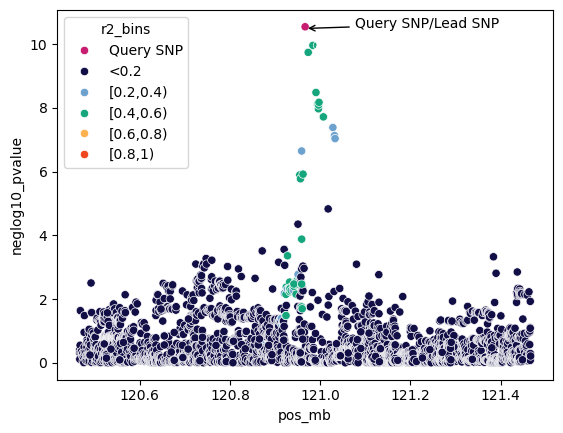

In [5]:
most_sig_snp = most_significant.rs_number.to_list()[0]
most_sig_chr = most_significant.chromosome.to_list()[0]
most_sig_pos = most_significant.position.to_list()[0]
min_pos = most_sig_pos - 500_000
max_pos = most_sig_pos + 500_000
assert(most_sig_chr == 7),f"what?? it should be chr 7 cuz we queried chr 7"
plot_region = sumstat_res.query(
  f"chromosome == {most_sig_chr} & position >= {min_pos} & position <= {max_pos}"
)

# get the plot data
ld_data = pd.read_csv("/Users/kevinliang/Desktop/work/working/interview_prep/5prime/5PrimeSciences_coding_assessments/data/lead_chr7_proxy.tsv",sep="\t",quoting=csv.QUOTE_NONE)[['RS_Number',"R2"]]
plot_data = pd.merge(
  plot_region[['position','rs_number','p-value','_-log10_p-value']],
  ld_data,
  how='left',left_on=['rs_number'],right_on=['RS_Number']
).copy()
# modify stuff so the plot looks nice

## the units in mb
x_axis_units = 1_000_000
plot_data = plot_data.assign(
  pos_mb = lambda df: df['position']/x_axis_units
)
## rename so easier to reference.
plot_data = plot_data.rename(
  {
    "_-log10_p-value":"neglog10_pvalue"
  },axis=1
)
## fill in R2 without value to be 0 (so will be the same color)
plot_data['R2'] = plot_data['R2'].apply(
  lambda val: 0 if np.isnan(val) else val
)
def get_bins(val):
  if val < 0.2:
    bin_cat = "<0.2"
  elif 0.2 <= val < 0.4:
    bin_cat = "[0.2,0.4)"
  elif 0.4 <= val < 0.6:
    bin_cat = "[0.4,0.6)"
  elif 0.6 <= val < 0.8:
    bin_cat = "[0.6,0.8)"
  elif 0.8 <= val:
    bin_cat = "[0.8,1]"
  else:
    assert(False),f"what value are we doing...{val}"
  return bin_cat
plot_data['r2_bins'] = plot_data[['R2','rs_number']].apply(
  lambda df: "Query SNP" if df['rs_number'] == most_sig_snp else get_bins(df['R2']),
  axis=1
)
# create custom palette
c_palette = {
  "Query SNP":"#c71d71",
  "<0.2":"#120e46",
  "[0.2,0.4)":"#6ea2ce",
  "[0.4,0.6)":"#15a67d",
  "[0.6,0.8)":"#fdb24f",
  "[0.8,1)":"#ef471f"
}

fig,ax = plt.subplots()
sns.scatterplot(
  plot_data,
  x = "pos_mb", y="neglog10_pvalue",hue="r2_bins",ax=ax,
  hue_order = list(c_palette.keys()),palette=c_palette
)
# annotate the lead snp
ax.annotate(
  "Query SNP/Lead SNP", 
  xy=(0.5,0.95),
  xytext=(0.6,0.95),
  xycoords='axes fraction',
  arrowprops=dict(arrowstyle="->",facecolor='black')
)
ax.update(
  {
    "xlabel":"Position [MB]",
    "ylabel":r"$-log_{10}(p-value)$"
  }
)
plt.show()
fig.savefig(
  "/Users/kevinliang/Desktop/work/working/interview_prep/5prime/5PrimeSciences_coding_assessments/results/locuszoom_plot_python_chr7.pdf"
)


### Question 6

SNPs with A/T or G/C alleles are known as palindromic SNPs, because their alleles are represented by the same pair of letters on the forward and reverse strands. Write a function that detects SNPs palindromic with palindromic alleles (A/T, T/A, G/C, or C/G) and removes them if their allele frequency is within a specific threshold around the allele frequency of 0.5.


1. Test your created function: How many SNPs are palindromic and are within the threshold of 0.1 around the allele frequency of 0.5?

Solution:
  Refer to source code for function 
    function: detect_palindrome()

Notes:
  There were variants with allele frequencies stored as -9. These variants are not changed and kept by default

In [ ]:
threhsold = 0.1
sumstat_res['keep'] = sumstat_res[['reference_allele','other_allele','eaf']].apply(
  lambda df: detect_palindrome(a1 = df['reference_allele'],a2 = df['other_allele'],af = df['eaf'],threshold = threhsold),
  axis=1
)
palin_dropped_snps = sumstat_res.query("~keep")
palin_dropped_snps.shape

invalid_eaf = sumstat_res.query("eaf < 0 | eaf > 1")

Solution:


The threshold was 0.1. allele frequency boundaries are 0.4 to 0.5.

There 145,069 variants that fits this criteria. That is:
  palindromic and belong in this criteria.

Notes:
  There were 291,059 variants with invalid allele frequency of -9. These included palindromic snps. They are not checked.